# Cox-Ingersoll-Ross++ model in PyTorch
Thomas Viehmann, <tv@interestingrates.de>

In this notebook, we are implementing the Cox-Ingersoll-Ross++ given by Brigo and Mercurio [On Deterministic Shift Extensions of Short Rate Models](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=292060) model in PyTorch.

We wish to implement
- One-factor [Cox-Ingersoll-Ross](https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model) model.
- The shift extension from CIR to CIR++.
- Swaption pricing using [Jamshidian's decomposition](https://en.wikipedia.org/wiki/Jamshidian's_trick) in the one-factor model

And we would like many things, in particular swaption prices, to be differentiable by the model parameters in order to do calibration.

Recall that the CIR equation is
$$
dr_t = \alpha (\mu-r) dt + \sqrt{r} dr.
$$
The shifted version is typically given as
$$
r^{\text{shifted}}(t) = r^{\text{CIR}}(t) + \varphi(t)
$$
for some deterministic shift function $\varphi$.

However, we are interested in observations of fixed time intervals and a corresponding set of discrete maturities, where only integrals of $\varphi$ between time steps play a rôle, or more precisely, factors $F(t,T)=\exp(-\int_t^T \varphi d\tau)$. But these can be expressed as quotients
$$
\exp\left(-\int_t^T \varphi d\tau\right)=\frac{ZCB(t,T)}{ZCB^{\text{CIR}}(t,T)}.
$$
Indeed, we will not compute or work with $\varphi$ and substitute the above when applying Brigo or Mercurio's formulas (the same formulas as in the article mentioned above also appear in their book).

First we import a few modules.

In [1]:
import torch
import numpy
from matplotlib import pyplot
%matplotlib inline

We introduce a convenience function to wrap scalars and tensors in autograd `Variables`.

In [2]:
def wrap(x, **argv):
  if numpy.isscalar(x):
    x = torch.autograd.Variable(torch.FloatTensor([x]), **argv)
  elif isinstance(x, torch.FloatTensor):
    x = torch.autograd.Variable(x)
  elif isinstance(x, (torch.autograd.Variable, torch.nn.Parameter)):
    pass
  else:
    raise Exception("Nothing to help you with "+str(x))
  return x


For the Cox-Ingersoll-Ross model, we need the normal and non-central $\chi^2$ distributons.
We use approximations from Wikipedia (for the [Normal](https://en.wikipedia.org/wiki/Normal_distribution#Numerical_approximations_for_the_normal_CDF) and [non-central $\chi^2$](https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution#Approximation)).

In [3]:
a_for_erf = 8.0/(3.0*numpy.pi)*(numpy.pi-3.0)/(4.0-numpy.pi)
def erf_approx(x):
    return torch.sign(x)*torch.sqrt(1-torch.exp(-x*x*(4/numpy.pi+a_for_erf*x*x)/(1+a_for_erf*x*x)))
def erfinv_approx(x):
    b = -2/(numpy.pi*a_for_erf)-torch.log(1-x*x)/2
    return torch.sign(x)*torch.sqrt(b+torch.sqrt(b*b-torch.log(1-x*x)/a_for_erf))

def normal_cdf(x):
    return 0.5*(1.0+erf_approx(x/(2**0.5)))

def ncchi2_cdf(x,k,lam):
    # https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution#Approximation
    h = 1-2/3*(k+lam)*(k+3*lam)/(k+2*lam)**2
    p = (k+2*lam)/(k+lam)**2
    m = (h-1)*(1-3*h)
    z = ((x/(k+lam))**h-(1+h*p*(h-1-0.5*(2-h)*m*p)))/(h*(2*p)**0.5*(1+0.5*m*p))
    return normal_cdf(z)


We can test the quality of these approximations by comparing against `scipy`'s impementation of the distributions:

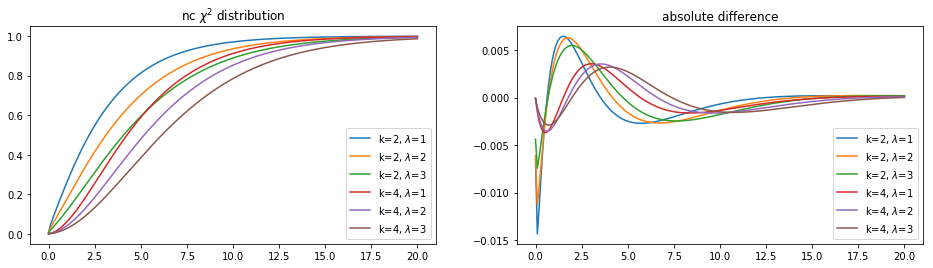

In [4]:
import scipy.stats
pyplot.figure(figsize=(16,4))
x = torch.linspace(0,20,200)
for k in (2,4):
    for lam in (1,2,3):
       cdf = ncchi2_cdf(x,k,lam)
       pyplot.subplot(1,2,1)
       pyplot.plot(x.numpy(),cdf.numpy(),label=r"k={}, $\lambda$={}".format(k,lam))
       pyplot.subplot(1,2,2)
       pyplot.plot(x.numpy(), scipy.stats.ncx2.cdf(x.numpy(),k,lam)-cdf.numpy(),label=r"k={}, $\lambda$={}".format(k,lam))
pyplot.subplot(1,2,1)
pyplot.legend()
pyplot.title('nc $\chi^2$ distribution')
pyplot.subplot(1,2,2)
pyplot.legend()
pyplot.title('absolute difference')

For the Jamshidian decomposition we need an implicitly defined critical rate $r^*$. This will be obtained by
gradient descent to minimize the square norm of the defining function to find the zero level set, i.e.
$f(x) = y$ where $y$ is given by $F(x,y)=0$.

The implicit function theorem readily provides a formula for the derivative, in order to backpropagate through
the implicit function, we define an autograd function. Details of the implementation and a brief mention of
mathematics is at my [Implicit functions in Pytorch Notebook](https://github.com/t-vi/pytorch-tvmisc/blob/master/misc/Implicit_Functions_Pytorch.ipynb). Note that the input may $x$ may be a vector, but the sought value $y$ needs to be a scalar as we do not compute the Jacobian and its inverse. But that is all we need.

In [5]:
class Implicit(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, y0, F, max_iter=200, reg=1e-6):
        y = torch.autograd.Variable(y0.clone(), requires_grad=True)
        xv = torch.autograd.Variable(x)
        opt = torch.optim.LBFGS([y], max_iter=max_iter)
        def reevaluate():
            opt.zero_grad()
            z = F(xv,y)**2
            z.backward()
            return z
        opt.step(reevaluate)
        xv = torch.autograd.Variable(x, requires_grad=True)
        y.grad = None
        z = F(xv,y)
        z.backward()
        ctx._dx_by_dy = xv.grad.data/(y.grad.data+y.grad.data.sign()*reg)
        return y.data
    @staticmethod
    def backward(ctx, output_grad):
        return -torch.autograd.Variable(ctx._dx_by_dy)*output_grad, None, None, None, None

We are now ready to define a CIR class implementing the Cox-Ingersoll-Ross model.
Instead of sampling from the noncentral $\chi^2$ distribution directly, we use the scheme proposed by 
[Andersen, Jaeckel, Kahl: Simulation of square-root processes](http://jaeckel.16mb.com/eqf013_009.pdf).

We need to discretise the time relatively finely because we need to keep track of the integrated path of the shortrate for the deflator (the inverse of the Numéraire).
We provide simulation and the textbook (e.g. Brigo and Mercurio) formulas for Zero Coupon Bonds and Options on Zero Coupon bonds.

Initialisation with a given intitial short rate facilitates the shift extension class below.

In [6]:
eps = 1e-8

class CIR:
    def __init__(self, alpha, mu, sigma, initr=None, rmax=1e4):
        self.alpha = alpha
        self.mu = mu
        self.sigma = sigma
        self.rmax = rmax
        self.initr = initr
    def get_params(self):
        return torch.cat([self.alpha, self.mu, self.sigma])
    def step(self, dt, r0, defl0):
        """A single step of size dt in the CIR process, starting at rate r0, deflator defl0 
        and returning new r,defl.
        Andersen, Jaeckel, Kahl: Simulation of square-root processes
        dr = alpha (mu-r) dt + sigma sqrt(r) dW_i
        """
        numSim = r0.size(0)
        exp_minus_alpha_dt = torch.exp(-self.alpha*dt)
        mean = self.mu+(r0-self.mu)*exp_minus_alpha_dt
        var = (r0*self.sigma**2*exp_minus_alpha_dt/self.alpha*(1-exp_minus_alpha_dt)
               +self.mu*self.sigma**2/(2*self.alpha)*(1-exp_minus_alpha_dt)**2)
        psi = var/mean**2
        # antithetics...
        Z0 = wrap(r0.data.new(numSim//2).normal_())
        Z = wrap(torch.stack([Z0,-Z0], 1).view(-1))
        #if psi < 1.5)
        b_sq = 2.0/psi-1+(2.0/psi*(2.0/psi-1))**0.5
        a = mean/(1+b_sq)
        b = b_sq**0.5
        r_psi_small = a*(b+Z)*(b+Z)
        if (r_psi_small>=eps).data.min() == 0:
            print ("oh")
            r_psi_small = r_psi_small.clamp(min=eps)

        # if psi >= 1.5
        p = (psi-1)/(psi+1);
        beta = 2.0/(mean*(psi+1.0))
        quantile = normal_cdf(Z)
        r_psi_large = (-torch.log(1-(quantile-p)/(1-p))/beta*(quantile>=p).float()).clamp(min=eps)

        psi_is_small = (psi<1.5).float()
        r = r_psi_small*psi_is_small+r_psi_large.clamp(max=self.rmax)*(1-psi_is_small)
        if (r==r).data.min() == 0:  # r==r is true unless r is NaN
            # this is what I did to analyse a problem
            # (before I clamped to rmax, I sometimes got r_psi_large=inf, 
            #  psi_is_small=1 and the rendering inf*0-->NaN)
            # it could go, but maybe it is instructive...
            print ("oh oh, NaN")
            print ("number of OK r",(r==r).sum())
            mask = 1-(r==r)
            print ("psi_is_small",(psi_is_small==psi_is_small).sum())
            print ("r_psi_large",(r_psi_large==r_psi_large).sum())
            print ("r_psi_small",(r_psi_small==r_psi_small).sum())
            print ("at NaNs",psi_is_small[mask], r_psi_large[mask], r_psi_small[mask])
        defl = defl0*torch.exp(-dt*(0.5*r0+0.5*r))
        return r, defl

    def simulate(self, num_sims, num_years, initr=None, steps_per_year=12):
        """Simulate the CIR process for a given number of years and simulations and keep the annual values"""
        assert (self.initr is None) != (initr is None), "either specify initial r at creation or in simulate"
        initr = initr if initr is not None else self.initr
        r0 = initr.expand(num_sims)
        d0 = wrap(torch.ones(num_sims))
        r = [r0]
        d = [d0]
        for i in range(num_years):
            for j in range(steps_per_year):
                r0,d0 = model.step(1.0/steps_per_year,r0,d0)
            r.append(r0)
            d.append(d0)
        r = torch.stack(r)
        d = torch.stack(d)
        return r,d

    def zcb_price(self, r, term, params=None):
        """Returns ZCB prices (= expected exponential integrated short rates) in the CIR model"""
        if params is None:
            alpha, mu, sigma = self.alpha, self.mu, self.sigma
        else:
            alpha, mu, sigma = torch.split(params, 1, dim=0)
        gamma = (alpha**2+2*sigma**2)**0.5
        nu = 2*alpha*mu/(sigma**2)
        w = (gamma+alpha)*torch.exp(gamma*term)+gamma-alpha
        A = (2*gamma*torch.exp(0.5*(gamma+alpha)*term)/w)**nu
        B = 2*(torch.exp(gamma*term)-1)/w
        return A*torch.exp(-B*r)

    def init_zcb_price(self, term):
        """Return initial ZCB prices, a convenience function for the shift extension"""
        assert self.initr is not None, "CIR model needs initial short rate"
        return self.zcb_price(self.initr, term)
        
    def call_zcb(self, term, tenor, X, r0): # Brigo Mercurio ZCB in CIR
        """Returns the price of a call option on a zero coupon bond.
        The option matures at term, the zero coupon bond at term+tenor.
        The strike ZCB price is X.
        The current (time 0) short rate is r0."""
        gamma = (self.alpha**2+2*self.sigma**2)**0.5
        nu = 2*self.alpha*self.mu/(self.sigma**2)
        w = (gamma+self.alpha)*torch.exp(gamma*tenor)+gamma-self.alpha
        A = (2*gamma*torch.exp(0.5*(gamma+self.alpha)*tenor)/w)**nu
        B = 2*(torch.exp(gamma*tenor)-1)/w
        rho = 2*gamma/(self.sigma**2*(torch.exp(gamma*term)-1))
        psi = (self.alpha+gamma)/(self.sigma**2)
        rbar = torch.log(A/X)/B
        
        d1 = 2*rbar*(rho+psi+B)
        d2 = 2*rbar*(rho+psi)
        
        dof = 4*self.alpha*self.mu/(self.sigma**2)

        lam1 = 2*rho**2*r0*torch.exp(gamma*term)/(rho+psi+B)
        lam2 = 2*rho**2*r0*torch.exp(gamma*term)/(rho+psi)
        
        Pbondmat = self.zcb_price(r0, term+tenor)
        Poptionexp = self.zcb_price(r0, term)
        
        return Pbondmat*ncchi2_cdf(d1, dof, lam1)-Poptionexp*X*ncchi2_cdf(d2, dof, lam2)



We are now ready to implement the shifted model of Brigo and Mercurio.

We take a fully initialized CIR model (that can give zero bond prices) and a desired Zero Coupon Bond curve.
The formulas follow Brigo and Mercurio with the substitution mentioned above and get formulas for the deflators (in the method `simulate`), zero coupon bonds (but this time, it is dependend on the time step, so we expect $r$ to be of shape $timesteps \times simulation$).

The function `call_atm_swap` implements pricing of at the money european swaptions using Jamshidians decomposition. The critical rate $r^*$ is defined as the one where the resulting swap rate is exactly the strike swap rate. Using that the forward swap rate $s$ is defined as 
$$f = \frac{ZCB(0,oterm)-ZCB(0,oterm+tenor)}{\sum_{i=oterm+1}^{oterm+tenor}ZCB(0,i)},$$
we can define the critical rate $r^*$ as the rate given by the equation
$$
F(\alpha,\mu,\sigma,r^*):=s_{\text{strike}} \sum_{i=oterm+1}^{oterm+tenor}ZCB(0,i) - (ZCB(0,oterm)-ZCB(0,oterm+tenor)) =0.
$$
The ZCB prices and thus the critical rate also depend on the model parameters $\alpha$, $\mu$, and $\sigma$.

In [7]:
class ShiftedModel:
  def __init__(self, basemodel, zcbs):
    self.zcbs  = zcbs
    self.basemodel = basemodel
    self.xzcbsbase = self.basemodel.init_zcb_price(wrap(torch.arange(0,zcbs.size(0)+1)))
    self.zcbsbase = self.xzcbsbase[1:]
    self.xzcbs = torch.cat((wrap(self.zcbs.data.new(1).fill_(1.0)),self.zcbs),dim=0)

  def simulate(self, num_sims, num_years, steps_per_year=12):
    r, d_base = self.basemodel.simulate(num_sims, num_years, steps_per_year=steps_per_year)
    numYears_plus_one = r.size(0)
    d = d_base*(self.xzcbs[:numYears_plus_one].unsqueeze(1)/self.xzcbsbase[:numYears_plus_one].unsqueeze(1))
    return r,d

  def zcb_price(self, r, term):
    numYears = r.size(0)-1
    assert len(self.zcbs)>=term+numYears
    forwardzcbs = self.xzcbs[term:]/self.xzcbs[:-term]
    forwardzcbsbase = self.xzcbsbase[term:]/self.xzcbsbase[:-term]
    forwardzcbfactors = forwardzcbs[:numYears+1]/forwardzcbsbase[:numYears+1]
    zcbPrice = self.basemodel.zcb_price(r, term)*forwardzcbfactors.unsqueeze(1)
    return zcbPrice

  def forward_zcb_prices_terms(self, r, t, maxterm, params=None):
    assert len(self.xzcbs) >= t+maxterm+1
    terms = wrap(torch.arange(0, maxterm+1))
    zcb_prices_base = self.basemodel.zcb_price(r, terms, params=params)
    forwardzcbsbase = zcb_prices_base/zcb_prices_base[0] #self.xzcbsbase[t:t+maxterm+1]/self.xzcbsbase[t]
    forwardzcbs = self.xzcbs[t:t+maxterm+1]/self.xzcbs[t]
    forwardzcbfactors = forwardzcbs/forwardzcbsbase
    zcbPrices = zcb_prices_base*forwardzcbfactors
    return zcbPrices
    
  def call_zcb(self, term, tenor, X, r0): # Brigo Mercurio ZCB in CIR
    zcb_factor_term_plus_tenor = self.xzcbs[term+tenor]/self.xzcbsbase[term+tenor]
    zcb_factor_term = self.xzcbs[term]/self.xzcbsbase[term]
    X_adj = X/(zcb_factor_term_plus_tenor/zcb_factor_term)
    return self.basemodel.call_zcb(term, tenor, X_adj, r0)*zcb_factor_term_plus_tenor

  def call_atm_swap(self, oterm, tenor, r0=wrap(0.01)):
    s = (self.xzcbs[oterm]-self.xzcbs[oterm+tenor])/self.xzcbs[oterm+1:oterm+tenor+1].sum()
    def F_jamshidian(params, r):
        zcbs = self.forward_zcb_prices_terms(r, oterm, tenor, params=params)
        return s*zcbs[1:].sum()+zcbs[tenor]-zcbs[0]

    params = self.basemodel.get_params()
    rstar = Implicit.apply(params, wrap(0.01), F_jamshidian) # where is sigma from?!
    zcbs = self.forward_zcb_prices_terms(rstar, oterm, tenor)
    price = (1+s)*self.call_zcb(oterm, tenor, zcbs[tenor], r0)
    for i in range(tenor-1):
        price += s*self.call_zcb(oterm, i+1, zcbs[i+1], r0)
    normvol = price*(((2*numpy.pi)/oterm)**0.5)/(self.xzcbs[oterm+1:oterm+tenor+1].sum())
    return price, normvol

We can test the our new class.
We use the spot (zero coupon swap rate) rates of 31 December 2016. 
These can be obtained from the usual providers, or freely from the Deutsche Bundesbank [published as part of the HGB §253 (2) discount rate information](http://www.bundesbank.de/Navigation/DE/Statistiken/Zeitreihen_Datenbanken/Geld_und_Kapitalmaerkte/geld_und_kapitalmaerkte_list_node.html?listId=www_skms_it05b).
The other parameters are made up, though.

In [8]:
num_sims = 100000
num_years = 10
spots = torch.FloatTensor([-0.00217, -0.00163, -0.00119, -0.00025, 0.0006, 0.00177, 0.00302, 0.00437, 0.00558, 0.00676, 0.0077, 0.00849, 0.00925, 0.00991, 0.01048, 0.01087, 0.01121, 0.01152, 0.01179, 0.01204])
zcbs = wrap((1+spots)**(-torch.arange(1,spots.size(0)+1)))
r0 = wrap(0.04)
alpha = wrap(0.2)
mu =    wrap(0.041)
sigma = wrap(0.05)
model = CIR(alpha, mu, sigma, initr=r0)
model2 = ShiftedModel(model, zcbs)

We can produce simulations for the short rate $r$ and the discount factor $defl$.

In [9]:
r,d = model2.simulate(num_sims, num_years, steps_per_year=12)

The first check is whether the mean deflator matches the zero cupon bonds, i.e. whether the simulation discount factors reflect the initial discount curve for fixed payments.

(Ideally we would produce confidence intervals to match standard practice, but that is for another day.)

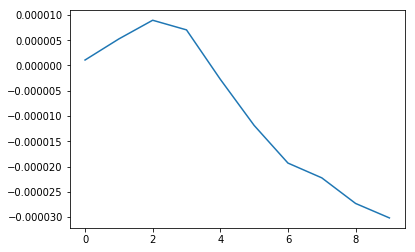

In [10]:
pyplot.plot((d[1:].mean(1)/zcbs[:d.size(0)-1]-1).data.numpy())

We can also do this for forward prices, e.g. for the 10-year ZCB in the future.

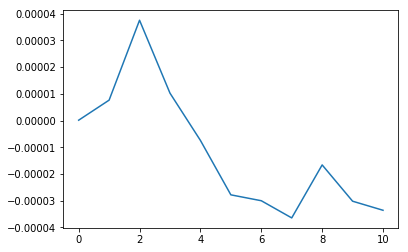

In [11]:
pyplot.plot((((model2.zcb_price(r,10)*d).mean(1)/zcbs[9:])-1).data.numpy())

We can also compare the Monte Carlo price, i.e. the discounted payoff, of a call option on a ZCB with the analytical price function.

In [12]:
def compare_zcb_call(term, tenor, strike):
  formula_price = model2.call_zcb(term, tenor, wrap(strike), r0)
  zcb_forward   = model2.zcb_price(r[:term+1], tenor).data.numpy()[term]
  d_term = d[term,:].data.numpy()
  mc_price = (numpy.fmax(zcb_forward-strike,0)*d_term).mean()
  return formula_price.data[0], mc_price

compare_zcb_call(5,1,0.9)

(0.09214048087596893, 0.092131287)

And we can also compare Monte Carlo price of a receiver swaption to the Jamshidian-calculated price.

In [13]:
def compare_swaption(term, tenor):
  atm_swap_rate = (model2.xzcbs[term]-model2.xzcbs[term+tenor])/model2.xzcbs[term+1:term+tenor+1].sum()
  zcb_forwards = torch.stack([model2.zcb_price(r[:term+1], t)[term] for t in range(1,tenor+1)])
  payoffs = (atm_swap_rate*zcb_forwards.sum(0)-(1-zcb_forwards[-1])).data.numpy()
  d_term = d[term,:].data.numpy()
  mc_price = (numpy.fmax(payoffs,0)*d_term).mean()
  formula_price,_ = model2.call_atm_swap(term, tenor, r0=r0)
  return mc_price, formula_price.data[0]
compare_swaption(10,10)

(0.022803003, 0.022926997393369675)

This is it for now, we will later discuss calibration of the CIR++ model.

I hope this notebook is informative for you. I read and appreciate every mail with feedback you send to <tv@interestingrates.de>.

Thomas Viehmann